In [96]:
from __future__ import division, print_function
import tensorflow as tf
import os
import random
import keras
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import re
from keras import optimizers
from keras import losses
from keras import regularizers
import keras.backend as K
from keras.models import model_from_json
from keras.models import load_model, Model
from tempfile import TemporaryFile
from keras import layers
from keras.callbacks import History, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation
from keras.layers import CuDNNLSTM, Dense, Bidirectional, Dropout, Layer
from keras.initializers import glorot_normal
from keras.regularizers import l2
import pandas as pd
import functools
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, \
    auc, average_precision_score, pairwise_distances
import scikitplot as skplt
import numpy as np
from numpy import inf, ndarray
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import pickle
import dill
from functools import partial
from multiprocessing import cpu_count, Pool
from keras.utils.generic_utils import Progbar
from copy import deepcopy
from NGF.utils import filter_func_args, mol_shapes_to_dims
import NGF.utils
import NGF_layers.features
import NGF_layers.graph_layers
from NGF_layers.features import one_of_k_encoding, one_of_k_encoding_unk, atom_features, bond_features, num_atom_features, num_bond_features
from NGF_layers.features import padaxis, tensorise_smiles, concat_mol_tensors
from NGF_layers.graph_layers import temporal_padding, neighbour_lookup, NeuralGraphHidden, NeuralGraphOutput
from math import ceil
from argparse import Namespace
import ast
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from scipy.spatial.distance import jensenshannon, cosine, pdist
from tqdm import tqdm
import sys
import seaborn as sns
sns.set()

In [97]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


# read gene features

In [98]:
cmap_zscore=pd.read_csv("cmap_gene_scores.csv",index_col=0).reset_index(drop=True)

# read the training,val,test splits

In [99]:
df_pairs=pd.read_csv("allpairs3_genes_new.csv",index_col=0).reset_index(drop=True)

/home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,8,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [100]:
df_pairs.value=df_pairs.value/2

(array([4.220000e+02, 4.141000e+03, 3.811400e+04, 3.262790e+05,
        1.585490e+06, 1.802477e+06, 8.053150e+05, 2.237570e+05,
        4.708700e+04, 2.354000e+03]),
 array([0.01712343, 0.09436539, 0.17160735, 0.2488493 , 0.32609126,
        0.40333322, 0.48057518, 0.55781714, 0.6350591 , 0.71230106,
        0.78954302]),
 <a list of 10 Patch objects>)

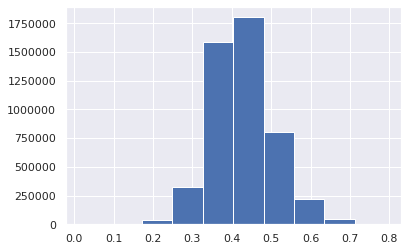

In [101]:
plt.hist(df_pairs.value)

In [102]:
moa_df = pd.read_csv("moa_df.csv",index_col=0,engine = "python").reset_index(drop=True)

In [103]:
info=pd.read_csv("../deepSNEM/data/graph_info_df/file_info_weighted.csv",index_col=0).reset_index(drop=True)

In [104]:
val1 = pd.read_csv("val_set_1_withoriginals.csv",index_col=0).reset_index(drop=True)
val2 = pd.read_csv("val_set_2_withoriginals.csv",index_col=0).reset_index(drop=True)
val3 = pd.read_csv("val_set_3_withoriginals.csv",index_col=0).reset_index(drop=True)
val4 = pd.read_csv("val_set_4_withoriginals.csv",index_col=0).reset_index(drop=True)
test=pd.read_csv("test_set_withoriginals.csv",index_col=0).reset_index(drop=True)

valsets = [val1,val2,val3,val4]
label_id = ['label1','label2','label3','label4']

In [105]:
sigs=list(set(list(df_pairs['sig_id_original.x'])+list(df_pairs['sig_id_original.y'])))
sigs_test=list(set(list(test['sig_id_original'])))

sigs_val1=list(set(list(val1['sig_id_original'])))
sigs_val2=list(set(list(val2['sig_id_original'])))
sigs_val3=list(set(list(val3['sig_id_original'])))
sigs_val4=list(set(list(val4['sig_id_original'])))
sigs_valset=[sigs_val1,sigs_val2,sigs_val3,sigs_val4]

# Tesnorize data

In [106]:
def tensorize_zscores(sig_list,gene_size,cmap):
    import numpy as np
    cols=list(cmap_zscore.columns)
    n=len(sig_list)
    X_genes=np.zeros((n,gene_size),dtype='float32')
    for idx,sig in enumerate(sig_list):
        X_genes[idx]=np.array(cmap_zscore[sig])
    
    return X_genes

In [107]:
gene_train=tensorize_zscores(sigs,978,cmap_zscore)

In [108]:
gene_test=tensorize_zscores(sigs_test,978,cmap_zscore)

In [109]:
gene_val1=tensorize_zscores(sigs_val1,978,cmap_zscore)
gene_val2=tensorize_zscores(sigs_val2,978,cmap_zscore)
gene_val3=tensorize_zscores(sigs_val3,978,cmap_zscore)
gene_val4=tensorize_zscores(sigs_val4,978,cmap_zscore)
gene_val_set=[gene_val1,gene_val2,gene_val3,gene_val4]

# only keep labels with more than 3 examples?

In [110]:
df_pairs['label1'][df_pairs[df_pairs["label"]==1][df_pairs[df_pairs["label"]==1]['count.x']<=3].index]=0
df_pairs['label2'][df_pairs[df_pairs["label"]==1][df_pairs[df_pairs["label"]==1]['count.x']<=3].index]=0
df_pairs['label3'][df_pairs[df_pairs["label"]==1][df_pairs[df_pairs["label"]==1]['count.x']<=3].index]=0
df_pairs['label4'][df_pairs[df_pairs["label"]==1][df_pairs[df_pairs["label"]==1]['count.x']<=3].index]=0

/home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

# Generators and metrics

In [111]:
def train_gen_random_moa(bs,df,df_labels,moa_df,sigs,gene_zscore):
    import numpy as np
    counter=int(0)
    #Keep looping indefinetely
    while True:
        
        #Initialize batches of inputs and outputs
        ind1 = []
        ind2 = []
        
        d=[]
        label = []
        #Keep looping until we reach batch size
        while len(ind1)<=bs: #doesn't matter if it is smi1 or smi2 since they have the same len
            
            # check to see if you reached the end of the frame
            if counter==len(df):
                counter=int(0)
                df = df.sample(frac=1).reset_index(drop=True)
            
            s1=df['sig_id_original.x'][counter]
            s2=df['sig_id_original.y'][counter]
            ind1.append(sigs.index(s1))
            ind2.append(sigs.index(s2))
            d.append(1-df.value[counter])
            label.append(df.label1[counter])
            counter+=1
        
        moa_sampled = moa_df.sample(25).reset_index(drop=True)
        for k in range(len(moa_sampled)):
            df_moa = df_labels[df_labels['moa_v1.x'] == moa_sampled['moa_v1.x'][k]].reset_index(drop=True)
            df_sampled = df_moa.sample(1).reset_index(drop=True)
            s1_extra=df_sampled['sig_id_original.x'][0]
            s2_extra=df_sampled['sig_id_original.y'][0]
            ind1.append(sigs.index(s1_extra))
            ind2.append(sigs.index(s2_extra))
            d.append(1-df_sampled.value[0])
            label.append(df_sampled.label1[0])
        
        in_vec_1=gene_zscore[ind1]


        in_vec_2=gene_zscore[ind2]

        
        # yield the batch to the calling function
        yield ({'gene_inputs_1':in_vec_1,'gene_inputs_2':in_vec_2,'moa_inputs':np.array(label,dtype='float32')},np.array(d,dtype = 'float32'))

In [112]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def get_cindex(y_true, y_pred):
    g = tf.subtract(tf.expand_dims(y_pred, -1), y_pred)
    g = tf.cast(g == 0.0, tf.float32) * 0.5 + tf.cast(g > 0.0, tf.float32)

    f = tf.subtract(tf.expand_dims(y_true, -1), y_true) > 0.0
    f = tf.matrix_band_part(tf.cast(f, tf.float32), -1, 0)

    g = tf.reduce_sum(tf.multiply(g, f))
    f = tf.reduce_sum(f)

    return tf.where(tf.equal(g, 0), 0.0, g/f)

def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [113]:
def custom_loss_2(labels):
    def double_cosine(y_true, y_pred):
        condition = tf.math.equal(labels,1)
        indices = tf.where(condition)
        sliced_sim = tf.gather_nd(y_pred,indices)
        mean_sim = tf.reduce_mean(tf.subtract(1.0,sliced_sim))
        return 0.5*tf.reduce_mean(K.square(y_pred - y_true), axis=-1) + 0.5*mean_sim
    return double_cosine

In [114]:
def metric_cosine(labels):
    def cosine(y_true, y_pred):
        condition = tf.math.equal(labels,1)
        indices = tf.where(condition)
        sliced_sim = tf.gather_nd(y_pred,indices)
        mean_sim = tf.reduce_mean(tf.subtract(1.0,sliced_sim))
        return mean_sim
    return cosine

# Model

In [115]:
def enc_genes(params):
        
    ### encode genes
    in_vec=Input(name='gene_inputs', shape=(978,),dtype = 'float32')
    
    fc1=keras.layers.Dense(params['dense_size_1'],activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(in_vec)
    fc1=keras.layers.Dropout(params['dropout_1'])(fc1)
    fc2=keras.layers.Dense(params['dense_size_2'],activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(fc1)
    fc2=keras.layers.Dropout(params['dropout_2'])(fc2)
    fc3=keras.layers.Dense(params['dense_size_3'],activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(fc2)
    #fc4=keras.layers.Dense(128,activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(fc3)
    #fc5=keras.layers.Dense(256,activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(fc4)
    #fc6=keras.layers.Dense(512,activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(fc5)
    embeddings = keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=1))(fc3)


    interactionModel = keras.Model(inputs=in_vec, outputs= embeddings)

    print(interactionModel.summary())
    return interactionModel

In [116]:
def siamese_model(params):
    # Initialize encoder
    encoder_nikos = enc_genes(params)

    # Initialize model
    in_vec_1=Input(name='gene_inputs_1', shape=(978,),dtype = 'float32')
    in_vec_2=Input(name='gene_inputs_2', shape=(978,),dtype = 'float32')



    label=Input(name='moa_inputs',shape=(1,),dtype='float32')

    encoded_1 = encoder_nikos(in_vec_1)
    encoded_2 = encoder_nikos(in_vec_2)

    prediction = keras.layers.dot([encoded_1,encoded_2],axes = 1, normalize=True)

    siamese_net = Model(inputs=[in_vec_1,in_vec_2,label],outputs=prediction)
    print(siamese_net.summary())
    adam = keras.optimizers.Adam(lr=params['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
    siamese_net.compile(optimizer= adam,loss= custom_loss_2(label),metrics=['mse', get_cindex, r_square, pearson_r,metric_cosine(label)])
    
    return([siamese_net,encoder_nikos])

# Hyper parameter tuning

In [117]:
# defining the space
fspace = {
    'learning_rate' : hp.uniform('learning_rate', 0.0001, 0.01),
    'epoches' : hp.quniform('epoches',1,10,1),
    'dense_size_1': hp.quniform('dense_size_1',128,1024,128),
    'dense_size_2': hp.quniform('dense_size_2',128,1024,128),
    'dense_size_3': hp.quniform('dense_size_3',128,1024,128),
    'dropout_1': hp.quniform('dropout_1', 0.1, 0.3, 0.05),
    'dropout_2': hp.quniform('dropout_1', 0.1, 0.3, 0.05)
}

In [130]:
def objective(fspace, df_pairs, gene_val_set, gene_train, valsets,moa_df, sigs,sigs_valset):
    accs = []
    model_params = {
        "learning_rate" : fspace['learning_rate'],
        "epoches" : int(fspace['epoches']),
        "dense_size_1" : int(fspace['dense_size_1']),
        "dense_size_2" : int(fspace['dense_size_2']),
        "dense_size_3" : int(fspace['max_delta_step']),
        "dropout_1" : fspace['dropout_1'],
        "dropout_2" : fspace['dropout_2']
        }
    for i in range(len(valsets)):
        df_labels = df_pairs[df_pairs[label_id[i]]==1].reset_index(drop=True)
        def enc_genes(params):
            ### encode genes
            in_vec=Input(name='gene_inputs', shape=(978,),dtype = 'float32')
    
            fc1=keras.layers.Dense(params['dense_size_1'],activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(in_vec)
            fc1=keras.layers.Dropout(params['dropout_1'])(fc1)
            fc2=keras.layers.Dense(params['dense_size_2'],activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(fc1)
            fc2=keras.layers.Dropout(params['dropout_2'])(fc2)
            fc3=keras.layers.Dense(params['dense_size_3'],activation = None,kernel_regularizer=None, kernel_initializer='glorot_normal')(fc2)
            embeddings = keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=1))(fc3)


            interactionModel = keras.Model(inputs=in_vec, outputs= embeddings)

            #print(interactionModel.summary())
            return interactionModel
        
        #siamese_net=siamese_model[0](model_params)
        # Initialize encoder
        encoder_nikos = enc_genes(params)

        # Initialize model
        in_vec_1=Input(name='gene_inputs_1', shape=(978,),dtype = 'float32')
        in_vec_2=Input(name='gene_inputs_2', shape=(978,),dtype = 'float32')



        label=Input(name='moa_inputs',shape=(1,),dtype='float32')

        encoded_1 = encoder_nikos(in_vec_1)
        encoded_2 = encoder_nikos(in_vec_2)

        prediction = keras.layers.dot([encoded_1,encoded_2],axes = 1, normalize=True)

        siamese_net = Model(inputs=[in_vec_1,in_vec_2,label],outputs=prediction)
        #print(siamese_net.summary())
        adam = keras.optimizers.Adam(lr=params['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
        siamese_net.compile(optimizer= adam,loss= custom_loss_2(label),metrics=['mse', get_cindex, r_square, pearson_r,metric_cosine(label)])
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=1, min_lr=0.00001, verbose=1, min_delta=1e-5)
        term=keras.callbacks.TerminateOnNaN()
        bs=512
        NUM_EPOCHS = model_params["epoches"]
        df_pairs = df_pairs.sample(frac=1).reset_index(drop=True)
        #Set total number of training samples and tests samples
        NUM_TRAIN = len(df_pairs)
        trainGen=train_gen_random_moa(bs,df_pairs,df_labels,moa_df,sigs,gene_train)
        history = siamese_net.fit_generator(trainGen,
                                            steps_per_epoch= ceil(NUM_TRAIN/bs),
                                            epochs=NUM_EPOCHS,
                                            verbose = 1,
                                            shuffle = True,
                                            callbacks= [term, rlr])
        
        emb=encoder_nikos.predict(gene_train[i],batch_size=1024)
        emb_id=sigs
        output_embs_train={}
        output_embs_train.update({'emb':emb_id})
        for i in range(model_params['dense_size_3']):
            output_embs_train.update({'x_%s'%i:emb[:,i]})
        
        emb=encoder_nikos.predict(gene_val_set[i],batch_size=1024)
        emb_id=sigs_valset[i]
        output_embs={}
        output_embs.update({'emb':emb_id})
        for i in range(model_params['dense_size_3']):
            output_embs.update({'x_%s'%i:emb[:,i]})
        
        ###Write R code to evaluate embeddings and investigate k
        
        
        pred = bst.predict(dtest)
        accs.append(accuracy_score(val_sigs['moa_categorical'], pred))
    ave_acc = np.mean(accs,axis = 0)
    return {'loss': -ave_acc ,  'status': STATUS_OK}

In [131]:
fmin_objective = partial(objective, df_pairs = df_pairs, gene_val_set = gene_val_set,gene_train=gene_train, valsets = valsets, moa_df=moa_df, sigs=sigs,sigs_valset=sigs_valset)

In [136]:
def run_trials():

    trials_step = 1000  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 1  # initial max_trials. put something small to not have to wait

    
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("my_model.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    best = fmin(fn = fmin_objective, space = fspace, algo=tpe.suggest, max_evals=max_trials, trials=trials)

    print("Best:", best)
    
    # save the trials object
    with open("my_model.hyperopt", "wb") as f:
        pickle.dump(trials, f)
    return(trials)

In [137]:
trials = run_trials()

Found saved Trials! Loading...
Rerunning from 21 trials to 1021 (+1000) trials
100%|█████████████████████████████████████████| 1021/1021 [8:14:38<00:00, 29.07s/trial, best loss: -0.6027980422938406]
Best: {'colsample_bylevel': 0.35788804057451146, 'colsample_bytree': 0.1226530432425497, 'gamma': 0.1571640395272282, 'learning_rate': 0.8098321148828739, 'max_bin': 176.0, 'max_delta_step': 5.0, 'max_depth': 11.0, 'min_child_weight': 10.0, 'reg_alpha': 2.0041642106706092, 'reg_lambda': 69.63017517747672, 'subsample': 0.7429682334802664}


In [ ]:
best_params = trials.trials[index]['misc']['vals']

# load the best parameters

In [185]:
best_params = trials.trials[index]['misc']['vals']
hyper_params = {
        "colsample_bylevel" : 0.35788804057451146,
        "colsample_bytree" : 0.1226530432425497,
        "gamma" : 0.1571640395272282,
        "eta" : 0.8098321148828739,
        "max_delta_step" : 5,
        "max_depth" : 11,
        "min_child_weight" : 10,
        "alpha" : 2.0041642106706092,
        "lambda" : 69.63017517747672,
        "subsample" : 0.7429682334802664,
        "objective":'multi:softmax',
        'num_class': all_df['moa_categorical'].nunique(),
        "booster":'gbtree',
        "eval_metric":'merror'
}

In [188]:
accs = []
for i in range(len(valsets)):
    val_genes = genes.loc[valsets[i]["sig_id"]]
    val_sigs = all_df.loc[valsets[i]["sig_id"]]
    train_genes = genes.drop(valsets[i]["sig_id"])
    train_sigs = all_df.drop(valsets[i]["sig_id"])
    dtrain = xgb.DMatrix(data=train_genes, label=train_sigs['moa_categorical'])
    dtest = xgb.DMatrix(data=val_genes, label = val_sigs['moa_categorical'])
    evalist = [(dtest,'eval'),(dtrain,'train')]
    bst = xgb.train(hyper_params, dtrain, 100, evalist, early_stopping_rounds = 10, verbose_eval = False)
    pred = bst.predict(dtest)
    accs.append(accuracy_score(val_sigs['moa_categorical'], pred))
ave_acc = np.mean(accs,axis = 0)

In [189]:
accs

[0.6554621848739496,
 0.5076923076923077,
 0.6326530612244898,
 0.6153846153846154]

# Test performance

In [198]:
val_genes = genes.loc[valsets[0]["sig_id"]]
val_sigs = all_df.loc[valsets[0]["sig_id"]]
train_genes = genes.drop(valsets[0]["sig_id"])
train_sigs = all_df.drop(valsets[0]["sig_id"])
dtrain = xgb.DMatrix(data=train_genes, label=train_sigs['moa_categorical'])
dval = xgb.DMatrix(data=val_genes, label = val_sigs['moa_categorical'])
dtest = xgb.DMatrix(data=test_genes)
evalist = [(dval,'eval'),(dtrain,'train')]
bst = xgb.train(hyper_params, dtrain, 100, evalist, early_stopping_rounds = 10, verbose_eval = False)
pred = bst.predict(dtest)
print(accuracy_score(test_sigs['moa_categorical'], pred))

0.46153846153846156


In [90]:
#le.inverse_transform(pred.astype(int))